# CNRS Applications study
---

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Loading the data
---

In [2]:
pd_candidates = pd.read_json('outputs/y19-20-21-22-s7-21-22-51.json')

## Some way to plot the data
---
Please don't judge for for the way I handle DataFrames

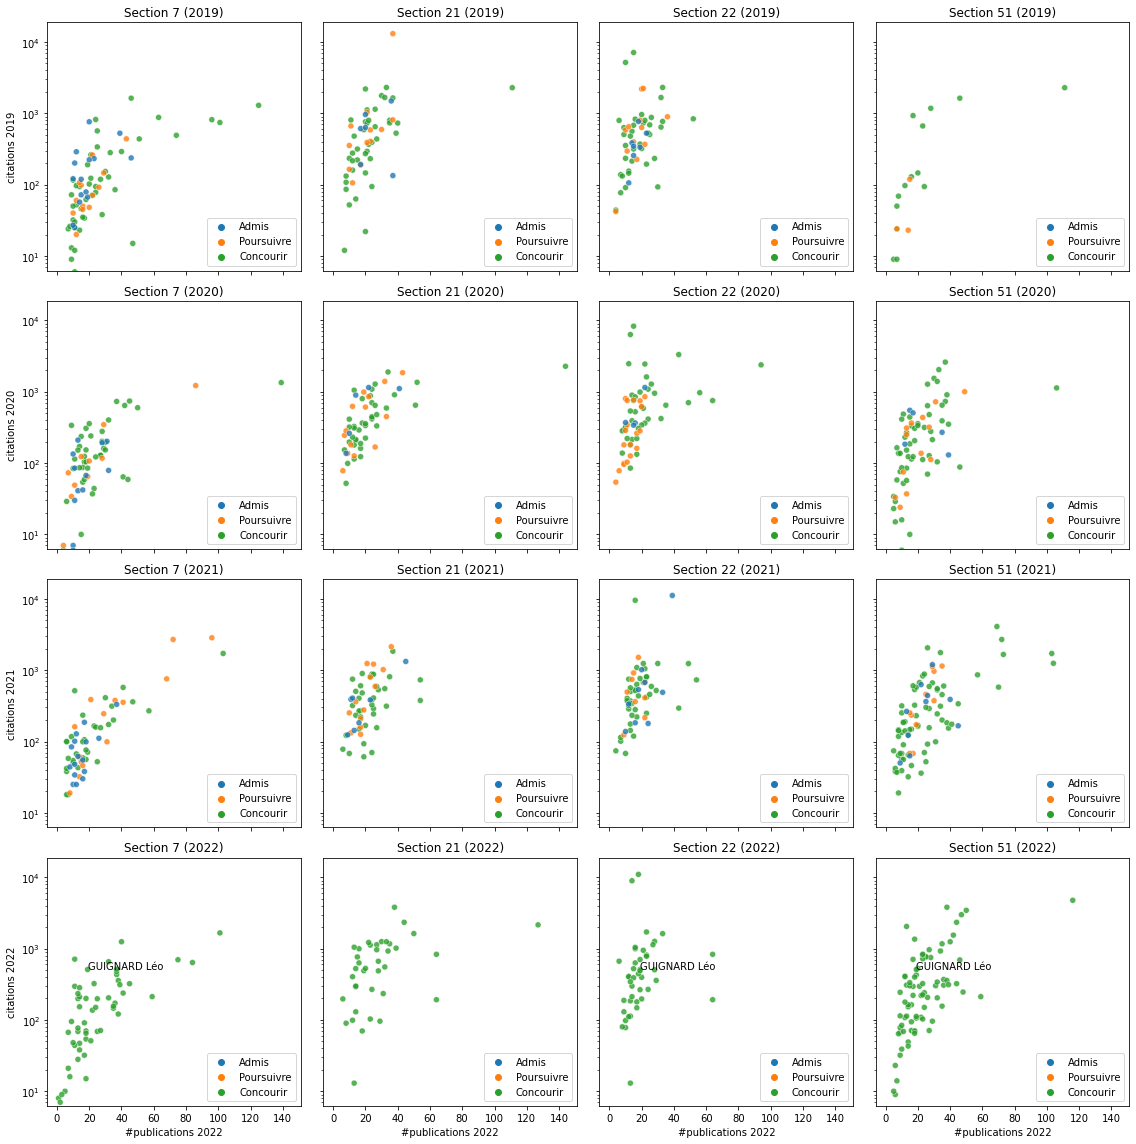

In [3]:
# You can add names bellow to plot them in the plots
to_look = ['GUIGNARD Léo']

hue_order = ['Admis', 'Poursuivre', 'Concourir']
ad_order = {'Admis': 3, 'Poursuivre': 2, 'Concourir': 1}
fig, axes = plt.subplots(4, 4, figsize=(16, 16), sharex=True, sharey=True)
axes = axes.flatten()
[ax.set(yscale='log') for ax in axes]
i = 0
years = range(2019, 2023)
sections = ['7', '21', '22', '51']
for year in years:
    for section in sections:
        ax = axes[i]
        i += 1
        tmp = pd_candidates[pd_candidates[f'{year} {section} section']]
        tmp = tmp.sort_values(by=f'{year} {section} Admissibility',
                              key=lambda v: list(map(ad_order.get, v)), ascending=True)
        sns.scatterplot(ax=ax, data=tmp, x=f'#publications {year}', y=f'citations {year}',
                        hue=f'{year} {section} Admissibility',
                        hue_order=hue_order, alpha=.8)
        ax.legend(loc='lower right')
        ax.set_title(f'Section {section} ({year})')
        for n in to_look:
            if n in pd_candidates[pd_candidates[f'{year} {section} section']]['Name'].to_list():
                x = pd_candidates[pd_candidates['Name']==n][f'#publications {year}']
                y = pd_candidates[pd_candidates['Name']==n][f'citations {year}']
                ax.text(x, y, n)
fig.tight_layout()
fig.savefig(f'outputs/publication_plot_split.png')

## Some other way to plot the data
---
Again, please don't judge me for the way I handle DataFrames :/

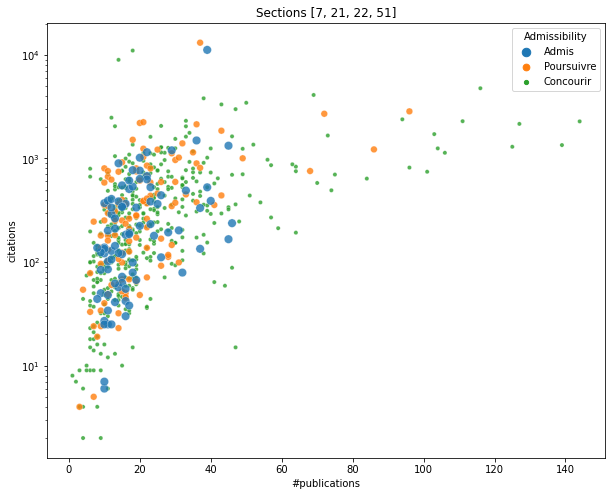

In [4]:
import pandas as pd

comp_order = lambda v: [ad_order.get(v[0], -1), v[1]]
out = {}
for y in years:
    for s in sections:
        tmp = pd_candidates[pd_candidates[f'{y} {s} section']]
        for k, v in zip(tmp['Name'], tmp[f'{y} {s} Admissibility']):
            out.setdefault(k, []).append((v, y))
best = {k: max(v, key=comp_order) for k, v in out.items()}
data = []
for n, info in best.items():
    tmp = pd_candidates[pd_candidates['Name']==n]
    data.append([n, info[0], int(tmp[f'#publications {info[1]}']), int(tmp[f'citations {info[1]}'])])
data = pd.DataFrame(data, columns=['Name', 'Admissibility', '#publications', 'citations'])
sorted_data = data.sort_values(by='Admissibility',
                               key=lambda v: list(map(ad_order.get, v)), ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
ax.set(yscale='log')
sns.scatterplot(data=sorted_data, x='#publications', y='citations', ax=ax, alpha=.8,
                hue='Admissibility', hue_order=hue_order, size='Admissibility', 
                size_order=hue_order);
ax.set_title(f'Sections {[int(v) for v in sections]}');
fig.savefig(f'outputs/all_together.png')

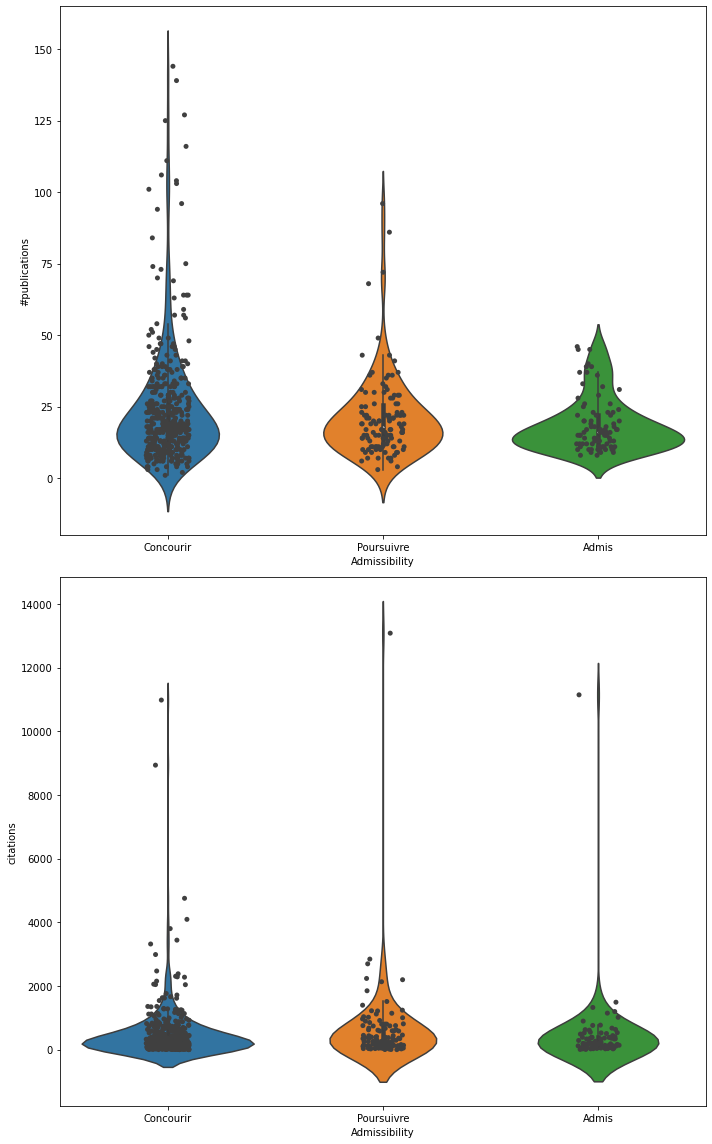

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 16))
sns.violinplot(data=sorted_data, y='#publications', x='Admissibility', ax=ax1)
sns.stripplot(data=sorted_data, y='#publications', x='Admissibility', ax=ax1, color=".25")
sns.violinplot(data=sorted_data, y='citations', x='Admissibility', ax=ax2)
sns.stripplot(data=sorted_data, y='citations', x='Admissibility', ax=ax2, color=".25")
fig.tight_layout()
fig.savefig('outputs/distrib.png')

In [6]:
from itertools import combinations
from scipy.stats import ks_2samp
for metric in ['#publications', 'citations']:
    vals = []
    for result in hue_order:
        vals.append((result, sorted_data[sorted_data['Admissibility']==result][metric]))
    print(metric)
    for (r1, v1), (r2, v2) in combinations(vals, 2):
        test = ks_2samp(v1, v2)
        print('{} vs {}, a={:.3f}, p={:.3f}'.format(r1, r2, test.statistic, test.pvalue))

#publications
Admis vs Poursuivre, a=0.143, p=0.243
Admis vs Concourir, a=0.149, p=0.077
Poursuivre vs Concourir, a=0.099, p=0.312
citations
Admis vs Poursuivre, a=0.177, p=0.079
Admis vs Concourir, a=0.114, p=0.293
Poursuivre vs Concourir, a=0.095, p=0.361
